In [1]:
from drn_interactions.load import load_neurons, load_spikes, get_derived_data_dir, load_derived_generic
from scipy.stats import zscore
from pathlib import Path
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "vscode"



from spiketimes.df.statistics import mean_firing_rate_by, cv2_isi_by
from drn_interactions.transforms import bin_spikes

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder


from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes


np.random.seed(42)
out_dir = get_derived_data_dir() / "clusters"
out_dir.mkdir(exist_ok=True, parents=True)

In [2]:
neurons = load_derived_generic("neurons/burst_features.csv")
neurons["waveform_width"] = neurons["waveform_width"].divide(30)

In [27]:
class Cluster:

    def __init__(self, df, scale_pipe, cluster_model, neuron_col="neuron_id"):
        self.df = df.copy()
        self.scale_pipe = scale_pipe
        self.neuron_col = neuron_col
        self.cluster_model = cluster_model
        self._scaled = None
        self._clusters = None
        
    
    @property
    def scaled(self):
        if self._scaled is None:
            scaled_data = self.scale_pipe.fit_transform(self.df)
            self._scaled = pd.DataFrame(scaled_data, columns=self.df.columns, index=self.df.index)
        return self._scaled
    
    @property
    def clusters(self):
        if self._clusters is None:
            clusters = self.cluster_model.fit_predict(self.scaled)
            self._clusters = pd.DataFrame({self.neuron_col: self.df.index.values, "cluster":clusters})
            self._clusters["cluster"] = pd.Categorical(self._clusters["cluster"])
        return self._clusters
    

    def update_clusters(self, mapper):
        self._clusters["cluster"] = self.clusters["cluster"].map(mapper)

    
    def get_elbow(self, start=2, stop=8):
        n_clusters = np.arange(start, stop + 1)
        error = np.empty(len(n_clusters))
        for i, k in enumerate(n_clusters):
            error[i] = KMeans(k).fit(self.scaled).inertia_
        return pd.DataFrame({"k": n_clusters, "WCSS": error})
    
    def get_bic(self, start=2, stop=8):
        n_clusters = np.arange(start, stop + 1)
        error = np.empty(len(n_clusters))
        for i, k in enumerate(n_clusters):
            error[i] = GaussianMixture(k).fit(self.scaled).bic(self.scaled)
        return pd.DataFrame({"k": n_clusters, "bic": error})


class CategoricalCluster(Cluster):
    def __init__(self, df, scale_pipe, cluster_model, neuron_col="neuron_id", categorical=None):
        super().__init__(df=df, scale_pipe=scale_pipe, cluster_model=cluster_model, neuron_col=neuron_col)
        self.categorical = categorical
    
    @property
    def clusters(self):
        if self._clusters is None:
            clusters = self.cluster_model.fit_predict(self.scaled, categorical=self.categorical)
            self._clusters = pd.DataFrame({self.neuron_col: self.df.index.values, "cluster":clusters})
            self._clusters["cluster"] = pd.Categorical(self._clusters["cluster"])
        return self._clusters


def plot_elbow(clusters, error, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    ax.scatter(clusters, error, color="black")
    ax.plot(clusters, error, color="black")
    ax.set_ylabel("WCSS")
    ax.set_xlabel("$k$ Clusters")
    return ax

def cluster_props(df_neurons, clusters, cluster_features):
    df = df_neurons[["neuron_id"] + list(cluster_features)].merge(clusters).drop("neuron_id", axis=1).groupby("cluster").median().reset_index()
    fig = go.Figure(data=[go.Table(
        header=dict(values=list(df.columns),
                    align='left'),
        cells=dict(values=[df[c] for c in df.columns],
                align='left'))
    ])
    fig.show()


def save_clusters(df,out_dir, name):
    df.to_csv(out_dir / f"{name}.csv", index=False)

def plot_scatter(df_neurons, cluster_col="cluster", cv_col="cv2_burst", mfr_col="mean_firing_rate", burst_col=None, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    return sns.scatterplot(data=df_neurons, hue=cluster_col, x=cv_col, y="mean_firing_rate", style=burst_col, ax=ax)

def plot_heatmap(scaled, clusters, vmin=-3, vmax=3, cmap="viridis"):
    plt.figure()
    # print(clusters)
    idx = clusters.sort_values("cluster").neuron_id.values
    return sns.heatmap(scaled.reindex(idx), vmin=-2, vmax=2, cmap=cmap)



def diagnose_clusters(mod: Cluster, df_neurons: pd.DataFrame, burst_col=None, error="elbow", 
heatmap_vmin=-2, heatmap_vmax=2, cmap="viridis"):
    if error == "elbow":
        elbow = mod.get_elbow()
        plot_elbow(elbow["k"], elbow["WCSS"])
    elif error == "bic":
        elbow = mod.get_bic()
        plot_elbow(elbow["k"], elbow["bic"])
    
    plot_heatmap(mod.scaled, mod.clusters, vmin=heatmap_vmin, vmax=heatmap_vmax, cmap=cmap)
    plot_scatter(df_neurons.merge(mod.clusters), burst_col=burst_col)
    cluster_props(df_neurons, mod.clusters, mod.scaled.columns)

In [28]:
def waveform_cluster(
    df_neurons, 
    n_clusters=4, 
    waveform_col="waveform_width", 
    mfr_col="mean_firing_rate", 
    cv_col="cv2_burst", 
    neuron_col="neuron_id",
    burst_col="is_burster",
    mapper=None,
    mfr_thresh=0.1,
    random_state=42,
    ):
    df = df_neurons.set_index(neuron_col)[[waveform_col, mfr_col, cv_col]].copy()
    df[waveform_col] = np.where(df[waveform_col] > 1.9, np.nan, df[waveform_col])
    df = df.loc[lambda x: x.mean_firing_rate >= mfr_thresh]
    scale_pipe = make_pipeline(KNNImputer(), StandardScaler())
    mod = Cluster(df=df, scale_pipe=scale_pipe, cluster_model=KMeans(n_clusters, random_state=random_state), neuron_col=neuron_col)
    if mapper is not None:
        mod.update_clusters(mapper)
    diagnose_clusters(mod, df_neurons, burst_col=burst_col)
    return mod

def no_waveform_cluster(
    df_neurons, 
    n_clusters=4, 
    mfr_col="mean_firing_rate", 
    cv_col="cv2_burst", 
    neuron_col="neuron_id",
    burst_col="is_burster",
    mapper=None,
    mfr_thresh=0.1,
    random_state=42,
    ):
    df = df_neurons.set_index(neuron_col)[[mfr_col, cv_col]].copy()
    df = df.loc[lambda x: x.mean_firing_rate >= mfr_thresh]
    scale_pipe = make_pipeline(KNNImputer(), StandardScaler())
    mod = Cluster(df=df, scale_pipe=scale_pipe, cluster_model=KMeans(n_clusters, random_state=random_state), neuron_col=neuron_col)
    if mapper is not None:
        mod.update_clusters(mapper)
    diagnose_clusters(mod, df_neurons, burst_col=burst_col)
    return mod

def waveform_burst_cluster(
    df_neurons, 
    n_clusters=4, 
    waveform_col="waveform_width", 
    mfr_col="mean_firing_rate", 
    cv_col="cv2_burst", 
    neuron_col="neuron_id",
    burst_col="is_burster",
    mapper=None,
    mfr_thresh=0.1,
    random_state=42,
    ):
    df = df_neurons.set_index(neuron_col)[[waveform_col, mfr_col, cv_col, burst_col]].copy()
    df[waveform_col] = np.where(df[waveform_col] > 1.9, np.nan, df[waveform_col])
    df = df.loc[lambda x: x.mean_firing_rate >= mfr_thresh]
    num_pipe = make_pipeline(KNNImputer(), MinMaxScaler())
    ct = make_column_transformer(
            (num_pipe, (waveform_col, mfr_col, cv_col)),
            (OneHotEncoder(drop="first"), [burst_col]), 
    )
    mod = Cluster(df=df, scale_pipe=ct, cluster_model=KMeans(n_clusters, random_state=random_state), neuron_col=neuron_col)
    if mapper is not None:
        mod.update_clusters(mapper)
    diagnose_clusters(mod, df_neurons, burst_col=burst_col, heatmap_vmin=0, heatmap_vmax=1, error="None")
    return mod

def waveform_burst_cluster_proto(
    df_neurons, 
    n_clusters=4, 
    waveform_col="waveform_width", 
    mfr_col="mean_firing_rate", 
    cv_col="cv2_burst", 
    neuron_col="neuron_id",
    burst_col="is_burster",
    mapper=None,
    mfr_thresh=0.1,
    random_state=42,
    gamma=None,
    ):
    df = df_neurons.set_index(neuron_col)[[waveform_col, mfr_col, cv_col, burst_col]].copy()
    df[waveform_col] = np.where(df[waveform_col] > 1.9, np.nan, df[waveform_col])
    df = df.loc[lambda x: x.mean_firing_rate >= mfr_thresh]
    num_pipe = make_pipeline(KNNImputer(), StandardScaler())
    ct = make_column_transformer(
            (num_pipe, (waveform_col, mfr_col, cv_col)),
            (OneHotEncoder(drop="first"), [burst_col]), 
    )
    mod = CategoricalCluster(df=df, 
        scale_pipe=ct, cluster_model=KPrototypes(n_clusters, random_state=random_state, gamma=gamma), 
        neuron_col=neuron_col, categorical=[3])
    if mapper is not None:
        mod.update_clusters(mapper)
    diagnose_clusters(mod, df_neurons, burst_col=burst_col, heatmap_vmin=-1.5, heatmap_vmax=1.5, error="None", cmap="viridis")
    return mod

def rename_merge(d):
    out = None
    for name, df in d.items():
        df = df.copy()
        if out is None:
            out = df[["neuron_id"]]
        out = df.rename(columns={"cluster":name}).merge(out, how="outer")
    return out
        
        

In [29]:
results = {}
# neurons = load_derived_generic(Path("neurons/burst_dea"))

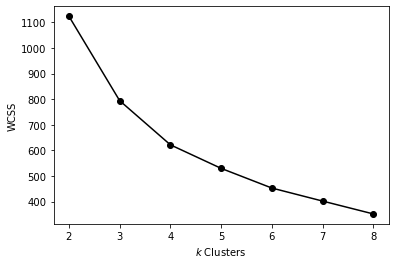

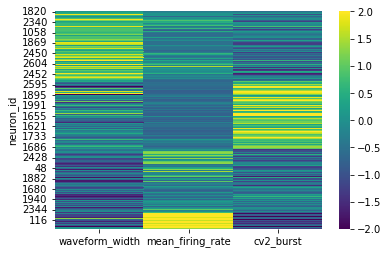

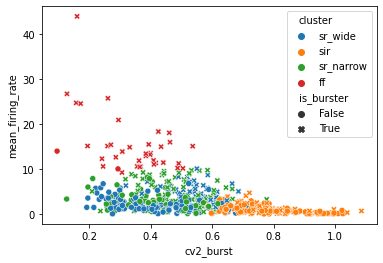

In [30]:

mapper = {0: "sr_wide", 1: "sir", 2: "sr_narrow", 3: "ff"}
results["wf_4"] = waveform_cluster(
    neurons, n_clusters=4,
    mapper=mapper,
    ).clusters

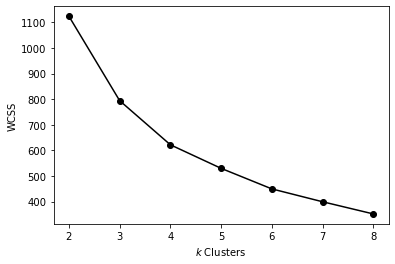

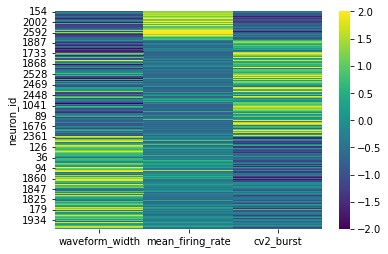

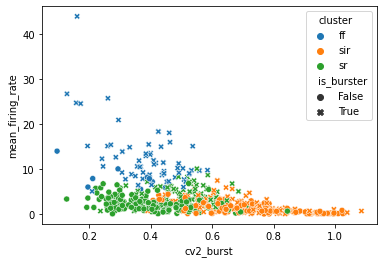

In [31]:

mapper = {0: "ff", 1: "sir", 2: "sr"}
results["wf_3"] = waveform_cluster(
    neurons, n_clusters=3,
    mapper=mapper,
    ).clusters

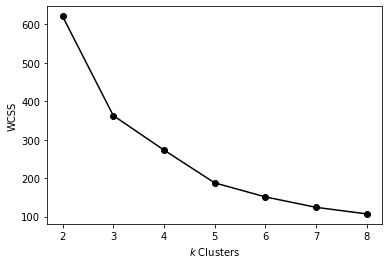

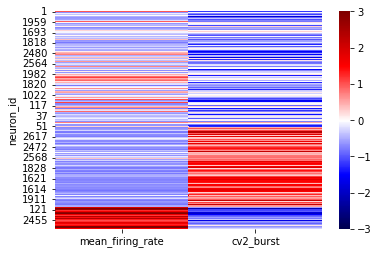

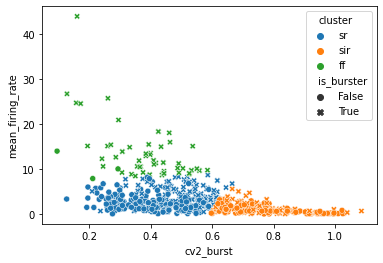

In [8]:
mapper = {0: "sr", 1: "sir", 2: "ff"}


results["no_wf_3"] = no_waveform_cluster(neurons, cv_col="cv2_burst", n_clusters=3, mapper=mapper).clusters

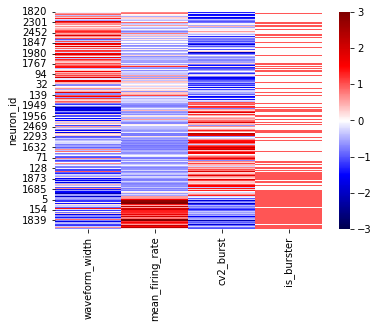

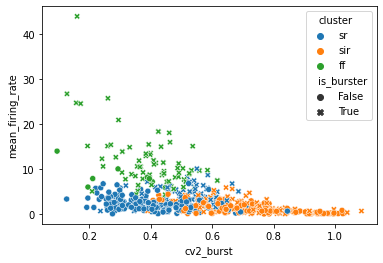

In [9]:

mapper = {0: "sr", 1: "sir", 2: "ff"}

results["burst_3"] = waveform_burst_cluster_proto(neurons, n_clusters=3, gamma=1, mapper=mapper).clusters

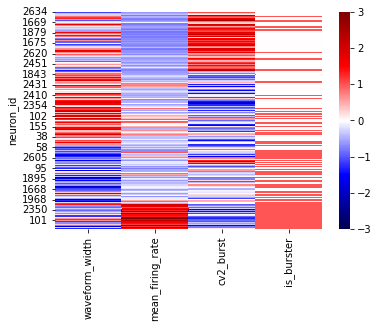

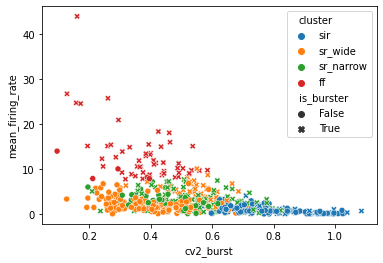

In [10]:
mapper = {0: "sir", 1: "sr_wide", 2: "sr_narrow", 3: "ff"}


results["burst_4"] = waveform_burst_cluster_proto(neurons, n_clusters=4, gamma=1, mapper=mapper).clusters

In [11]:
out = rename_merge(results)
out.head()

,neuron_id,burst_4,burst_3,no_wf_3,wf_3,wf_4
0,1,sr_narrow,sir,sr,sir,sr_narrow
1,4,sr_narrow,sir,sir,sir,sr_narrow
2,5,sr_narrow,ff,sr,sir,sr_narrow
3,6,sr_narrow,sir,sr,sir,sr_narrow
4,8,sr_wide,sr,sr,sr,sr_wide


In [12]:
out.to_csv(get_derived_data_dir() / "clusters.csv", index=False)